# EEG Classification Notebook


## Imports and Loading Data

In [1]:
!pip install keras-tuner
!pip install mat73
!pip install -U tensorflow-addons
#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
# extracted features that we corrected
mat_file = sio.loadmat('ExtractedFeatures_1s/data.mat')

# load labels to check accuracy
mat_file_labels = sio.loadmat('ExtractedFeatures_1s/label.mat')
count = 0
accuracy = []

In [3]:
data = mat_file['data']
labels = mat_file_labels['label']

# replicate labels for the 45 total experiments
labels = labels[0]
labels_edited = np.empty(675) #for every subject*experiment*trial
for i in range(0,45):
  labels_edited[i*15:(i+1)*15] = labels

data, labels_edited = shuffle(data, labels_edited)

In [4]:
cumul = []
for i in range(4): cumul.append([])

In [5]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)

#Cropping end time segments
data = data[:,:,0:250,:]

#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:550]
test_labels = labels_edited[550:600]
train_data = data[0:550]
test_data = data[550:600]
final_test = data[600:675]
final_labels = labels_edited[600:675]
cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

train_labels_reshaped = train_labels.reshape(-1,1) #Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1,1)
final_labels_reshaped = final_labels.reshape(-1,1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 3) #One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 3)
final_labels_reshaped = to_categorical(final_labels_reshaped, 3)

Unique: [0. 1. 2.], Counts: [31 24 20]
(550, 62, 250, 5) (550, 1250, 62)


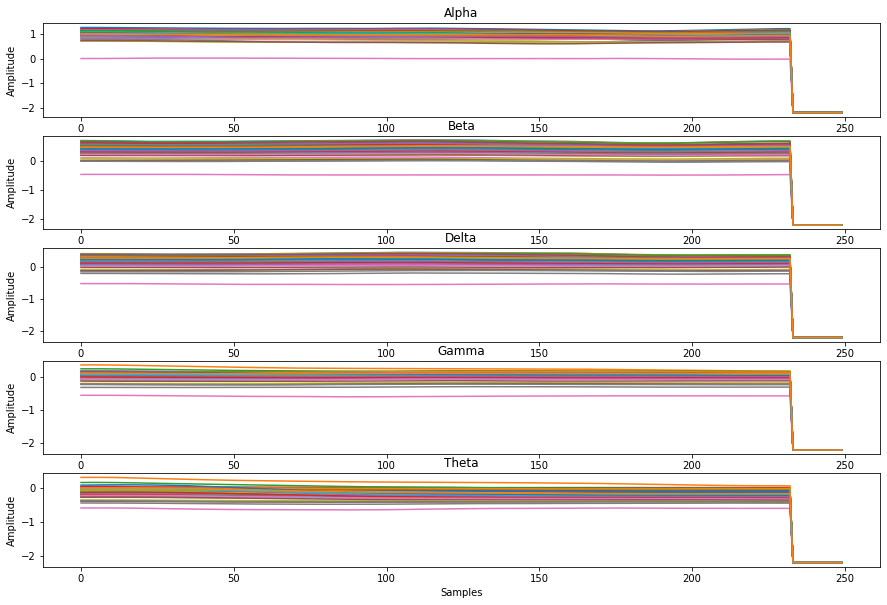

In [6]:
fig, a = plt.subplots(5, 1, squeeze= False, figsize= (15, 10))
titles = ['Alpha', 'Beta', 'Delta', 'Gamma', 'Theta']
for cnt in range(5):
  for i in range(len(test_data[5])):
    a[cnt][0].plot(range(len(test_data[5][i,:,cnt])), test_data[5][i,:,cnt])
  a[cnt][0].set_title(titles[cnt])
  a[cnt][0].set_xlabel('Samples')
  a[cnt][0].set_ylabel('Amplitude')

## Model Definitions

#### CNN Model


In [7]:
#Defining our CNN Model 

model = Sequential([
  Conv2D(filters= 64, kernel_size= 5, input_shape = (62,250,5), padding= 'same'), 
  Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  
  Dropout(rate= 0.3),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'), 
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  
  Dropout(rate= 0.2),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  
  Dropout(rate= 0.25),

  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides= 2),
  
  Dropout(rate= 0.3),
  
  Flatten(),

  Dense(512, activation= 'relu'),
  
  Dropout(rate= 0.4),
  Dense(256, activation= 'relu'),
  
  Dropout(rate= 0.2),
  Dense(64, activation= 'relu'),
  
  # softmax activation, convert final layer to probability distributions of the 3 emotional categories 
  Dense(3, activation= 'softmax')
])

# apply optimizer and categorical cross entropy loss function. measure accuracy of predictions, uses RMSE for insight on error magnitude
model.compile(optimizer= keras.optimizers.Adam(learning_rate=9e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 250, 64)       8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 250, 64)       36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 250, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 125, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 125, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 125, 128)      73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 125, 128)      1

## Training

#### CNN Training

In [16]:
#Training our CNN model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7) #patience = 5 and factor = 0.9

history = model.fit(
  train_data,
  train_labels_reshaped,
  batch_size = 64,
  epochs=100, 
  validation_data=(test_data, test_labels_reshaped),
  callbacks = [reduce_lr_cnn]
)

Epoch 1/100
9/9 [==============================] - 42s 5s/step - loss: 1.1210 - accuracy: 0.3600 - root_mean_squared_error: 0.4760 - val_loss: 1.0289 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.4542
Epoch 2/100
9/9 [==============================] - 43s 5s/step - loss: 1.0448 - accuracy: 0.4527 - root_mean_squared_error: 0.4590 - val_loss: 0.9662 - val_accuracy: 0.5000 - val_root_mean_squared_error: 0.4383
Epoch 3/100
9/9 [==============================] - 43s 5s/step - loss: 0.9160 - accuracy: 0.5600 - root_mean_squared_error: 0.4281 - val_loss: 0.8313 - val_accuracy: 0.6400 - val_root_mean_squared_error: 0.4066
Epoch 4/100
9/9 [==============================] - 48s 5s/step - loss: 0.7815 - accuracy: 0.5836 - root_mean_squared_error: 0.3957 - val_loss: 0.7217 - val_accuracy: 0.6800 - val_root_mean_squared_error: 0.3750
Epoch 5/100
9/9 [==============================] - 43s 5s/step - loss: 0.7011 - accuracy: 0.6673 - root_mean_squared_error: 0.3743 - val_loss: 0.7022 - val_

## Saving and Loading models

In [57]:
#NOTE: Loading pretrained models should only be done when the same data distribution (as shuffle is on) is also loaded otherwise you will get inflated results
model.save_weights("saved_weights/cnn_best.h5")
model.load_weights("saved_weights/cnn_best.h5")

'model_rnn.load_weights("/content/drive/MyDrive/Colab Notebooks/rnn_best.h5")\nmodel_hybrid.load_weights("/content/drive/MyDrive/Colab Notebooks/hybrid_best.h5")\nvit_classifier.load_weights("/content/drive/MyDrive/Colab Notebooks/vit_best.h5")'

## Results

#### Diagrams

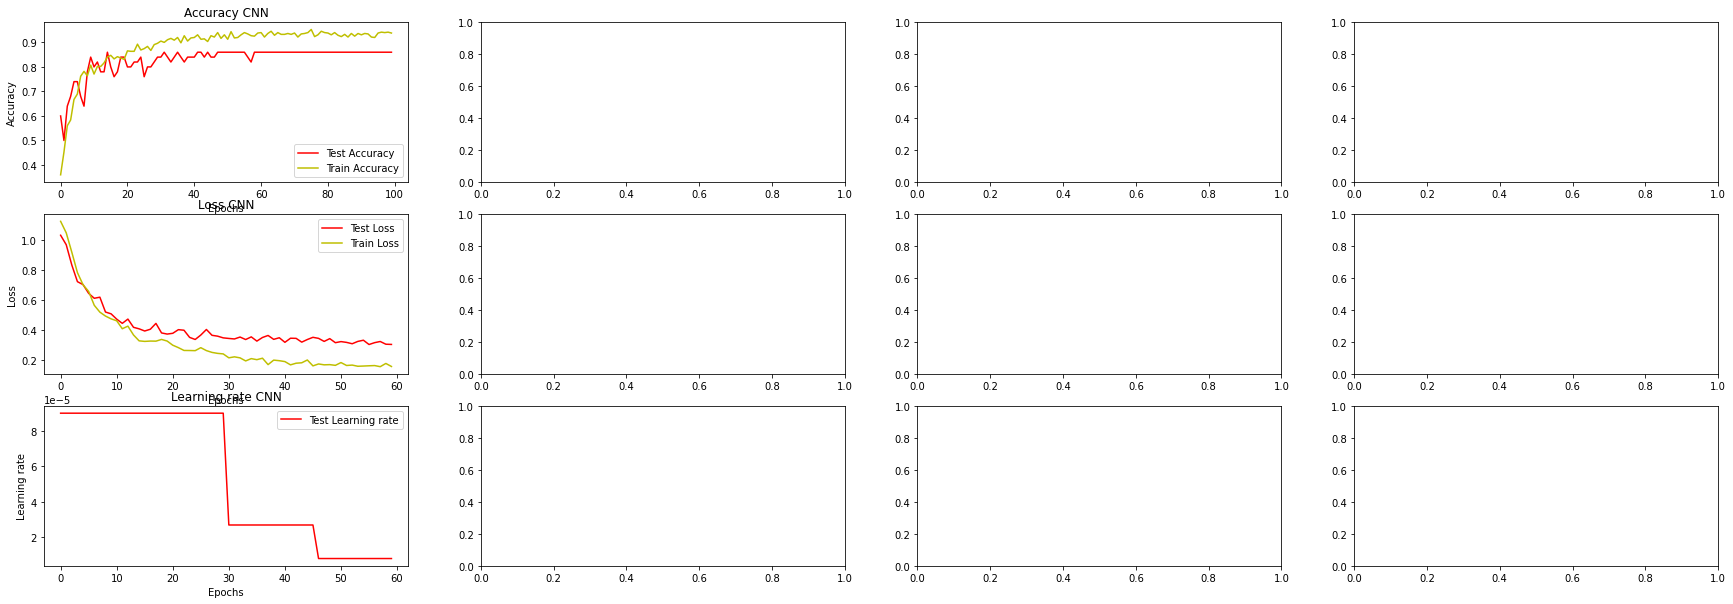

In [ ]:
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])


plt.rcParams["figure.figsize"] = (30,10)
fig, a = plt.subplots(3, 4, squeeze= False)

#plt.figure(1)
a[0][0].plot(range(0,epochs), history.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs), history.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy CNN')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Accuracy')
a[0][0].legend()
#plt.show()


#plt.figure(1)
a[1][0].plot(range(0,epochs - 40), history.history['val_loss'][0:60], 'r', label = 'Test Loss')
a[1][0].plot(range(0,epochs - 40), history.history['loss'][0:60], 'y', label = 'Train Loss')
a[1][0].set_title('Loss CNN')
a[1][0].set_xlabel('Epochs')
a[1][0].set_ylabel('Loss')
a[1][0].legend()
#plt.show()


#plt.figure(1)
a[2][0].plot(range(0,epochs - 40), history.history['lr'][0:60], 'r', label = 'Test Learning rate')
a[2][0].set_title('Learning rate CNN')
a[2][0].set_xlabel('Epochs')
a[2][0].set_ylabel('Learning rate')
a[2][0].legend()
#plt.show()


plt.show()

#### Metrics 

In [58]:
#Calculating Metrics, Confusion Matrices and Classification Reports
his = model.evaluate(x= final_test, y = final_labels_reshaped)
accuracy = his[1]
final_preds = np.empty([3, 75])
pred_labels = np.argmax(model.predict(final_test), axis=-1)


final_preds[0,:] = pred_labels


cf_cnn = sklearn.metrics.confusion_matrix(cf_labels, pred_labels, labels = [2,0,1])
cr = sklearn.metrics.classification_report(cf_labels, pred_labels, labels= [2,0,1])
mcc = sklearn.metrics.matthews_corrcoef(cf_labels, pred_labels)


print("\n", "Accuracy of CNN: " + str(accuracy))
print(f'MCC CNN: {mcc}\n')


#Use below code to save model and weights permanently


# with open('/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy', 'wb') as f:
#     np.save(f, data)
#     np.save(f, train_data)
#     np.save(f, test_data)
#     np.save(f, final_test)
# with open('/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy', 'rb') as f:
#     a = np.load(f)
#     b = np.load(f)
#     c = np.load(f)
#     d = np.load(f)
# print(np.testing.assert_allclose(d, final_test, err_msg= "FAIL"))

# model_json = model.to_json()
# with open("/content/drive/MyDrive/Colab Notebooks/cnn_best.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/MyDrive/Colab Notebooks/cnn_best.h5")
# print("Saved model to disk")

# # load json and create model
# json_file = open('/content/drive/MyDrive/Colab Notebooks/ensemble_best.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/ensemble_best.h5")
# print("Loaded model from disk")

# loaded_model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', 'categorical_accuracy', tf.keras.metrics.RootMeanSquaredError()])


3/3 [==============================] - 1s 286ms/step - loss: 0.2375 - accuracy: 0.8800 - root_mean_squared_error: 0.2286

 Accuracy of CNN: 0.8799999952316284
MCC CNN: 0.819960508292401



'print("\n", "Accuracy of CNN: " + str(accuracy), "Accuracy of RNN: " + str(accuracy_rnn), "Accuracy of Hybrid Model: " + str(accuracy_hybrid), "Accuracy ViT: " + str(accuracy_exp), "Accuracy Ensemble: " + str(accuracy_ensemble), "\n", "Confusion Matrix CNN: ", str(cf), "Confusion Matrix RNN: ", str(cf_rnn), "Confusion Matrix Hybrid: ", str(cf_hybrid), "Confusion Matrix ViT: ", str(cf_exp), "Confusion Matrix Ensemble: ", str(cf_ensemble), "\n", "Classification Report CNN: ", str(cr), "Classification Report RNN: ", str(cr_rnn),  "Classification Report Hybrid: ", str(cr_hybrid), "Classification Report ViT: ", str(cr_exp), "Classification Report Ensemble: ", str(cr_ensemble), sep= \'\n\')\nprint(f\'MCC CNN: {mcc}\n MCC RNN: {mcc_rnn}\n MCC Hybrid: {mcc_hybrid}\n MCC ViT: {mcc_exp}\n MCC Ensemble: {mcc_ensemble}\')\n'